In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## read csv

In [2]:
df = pd.read_csv ("/content/DailyTotalFemaleBirths.csv",parse_dates=['Date'], index_col='Date')
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


## plot data

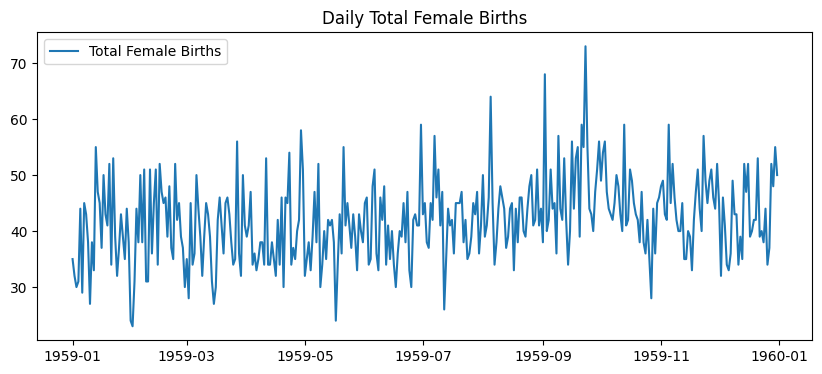

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(df, label='Total Female Births')
plt.legend(loc='upper left')
plt.title('Daily Total Female Births')
plt.show()

<Axes: xlabel='Date'>

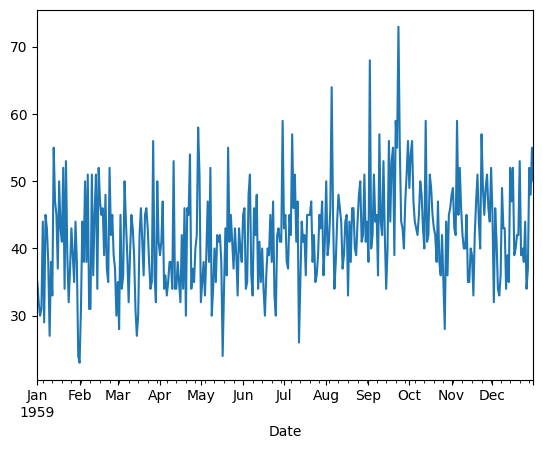

In [4]:
df['Births'].plot()

## check stationarity

In [5]:
result = adfuller(df['Births'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#data is not stationary cause the p-value isn't less than 0.05

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05


## ACF

## PACF

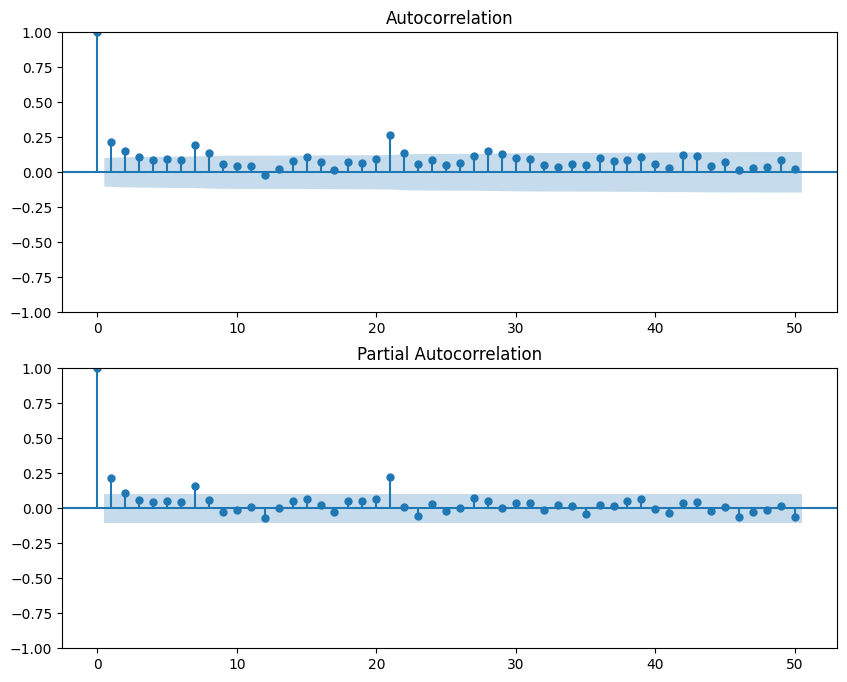

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df, lags=50, ax=ax1)
plot_pacf(df, lags=50, ax=ax2)

plt.show()


##  Applay decomposition and plot each component.

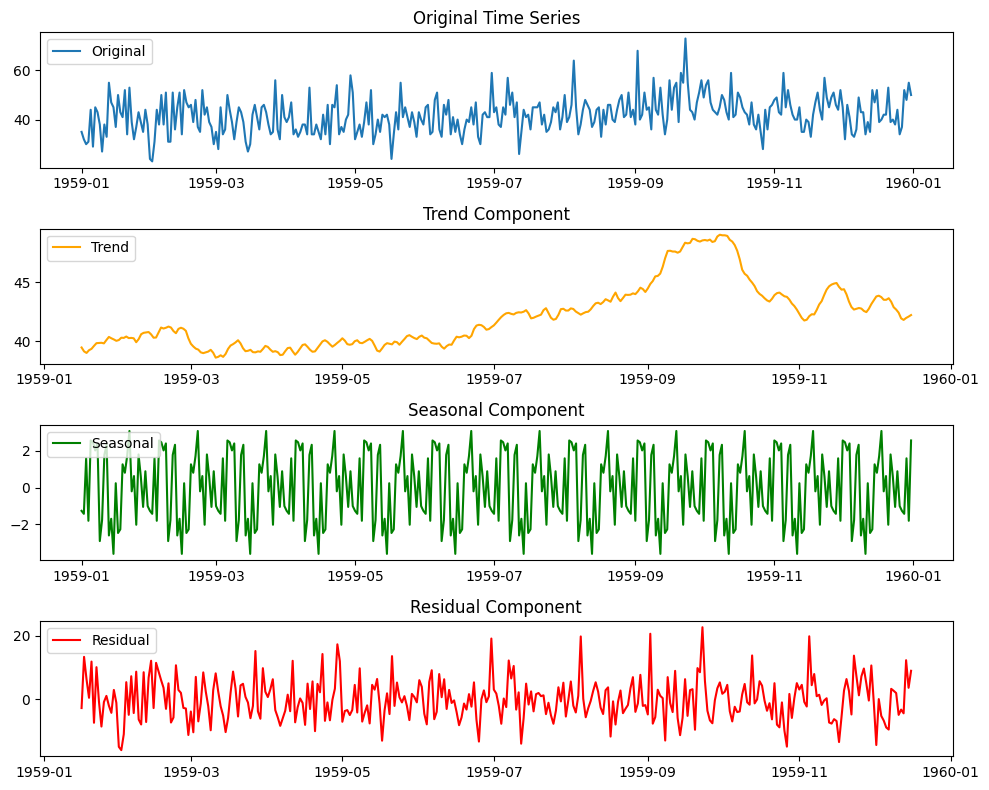

In [7]:

decomposition = seasonal_decompose(df['Births'], model='additive', period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(df['Births'], label='Original')
ax1.legend(loc='upper left')
ax1.set_title('Original Time Series')

ax2.plot(decomposition.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_title('Trend Component')

ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal Component')

ax4.plot(decomposition.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()


## Apply the first difference and plot the data

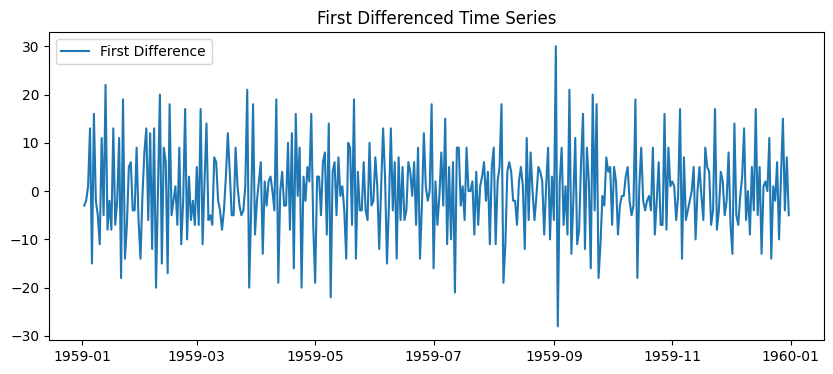

In [8]:

df_diff = df.diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(df_diff, label='First Difference')
plt.legend(loc='upper left')
plt.title('First Differenced Time Series')
plt.show()


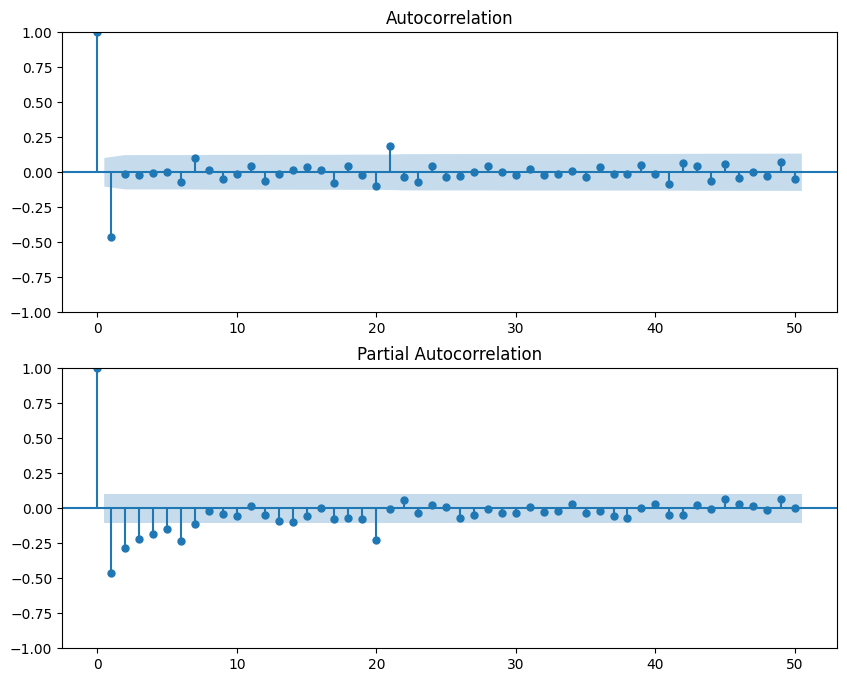

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df_diff, lags=50, ax=ax1)
plot_pacf(df_diff, lags=50, ax=ax2)

plt.show()


# split the data into 80% training and 20% testing.

In [10]:

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

len(train), len(test)


(292, 73)

## Applay 3 different ARIMA(AR,MA,ARMA,ARIMA,SARIMA) models, explain which model is best, and why.

In [ ]:
#  AR Model (ARIMA with order=(p,0,0))
order_ar = (21, 0, 0)
model_ar = ARIMA(train, order=order_ar)
model_ar_fit = model_ar.fit()
print(model_ar_fit.summary())

# Forecast
forecast = model_ar_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

In [12]:
def evaluate_arima_model(order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    return mse, mae,predictions

# ARIMA(1,0,0)
mse_ar1, mae_ar1,forecast = evaluate_arima_model((0, 1, 1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


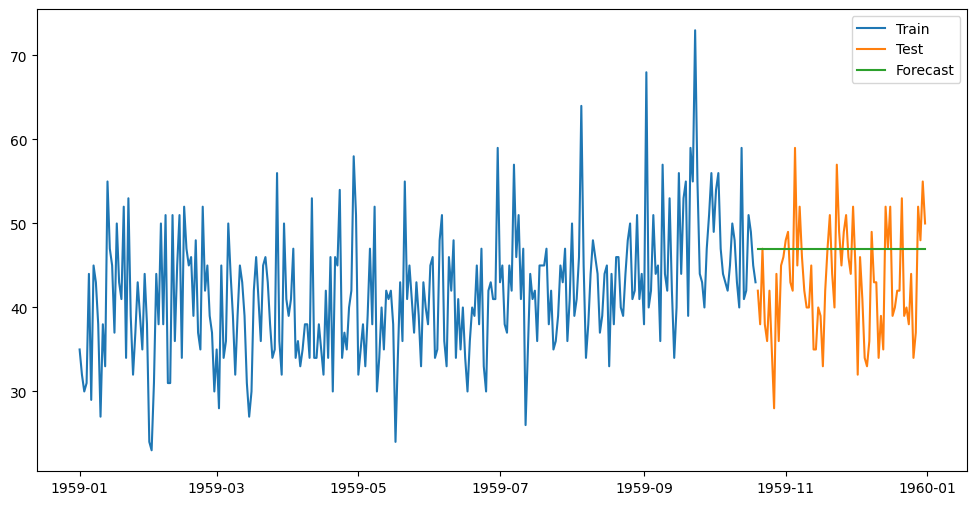

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

In [14]:
print(f"mse_ar1:{mse_ar1}, mae_ar1:{mae_ar1 }" )

mse_ar1:57.113216694345496, mae_ar1:6.223773647720649


In [15]:
# MA(0,0,1)
mse_ma1, mae_ma1 ,forecast2= evaluate_arima_model((0, 0,1 ))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


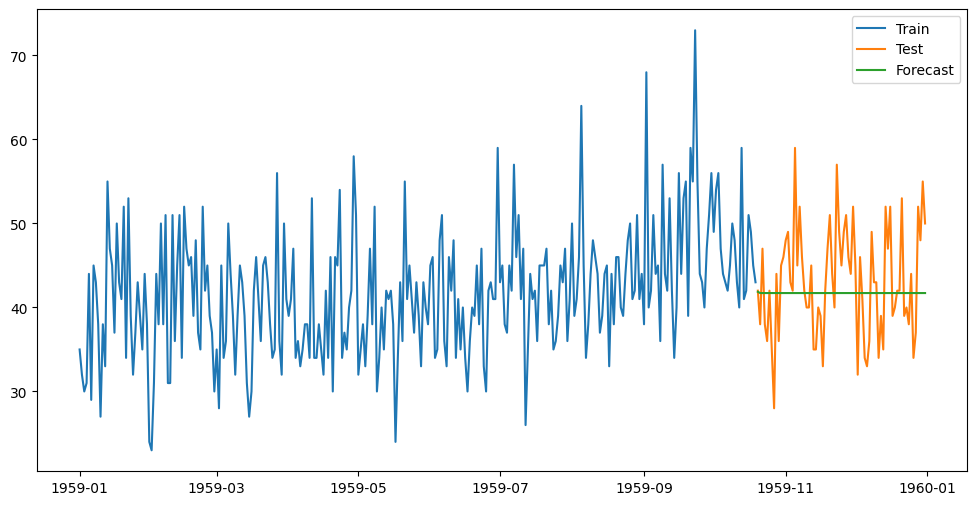

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast2, label="Forecast")
plt.legend()
plt.show()

In [17]:
print(f"mse_ma1:{mse_ma1}, mae_ma1:{mae_ma1 }" )

mse_ma1:42.9737696738368, mae_ma1:5.302526309805811


In [18]:
# ARMA(1,0,1)
mse_arma, mae_arma ,forecast3 = evaluate_arima_model((21, 0, 0))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


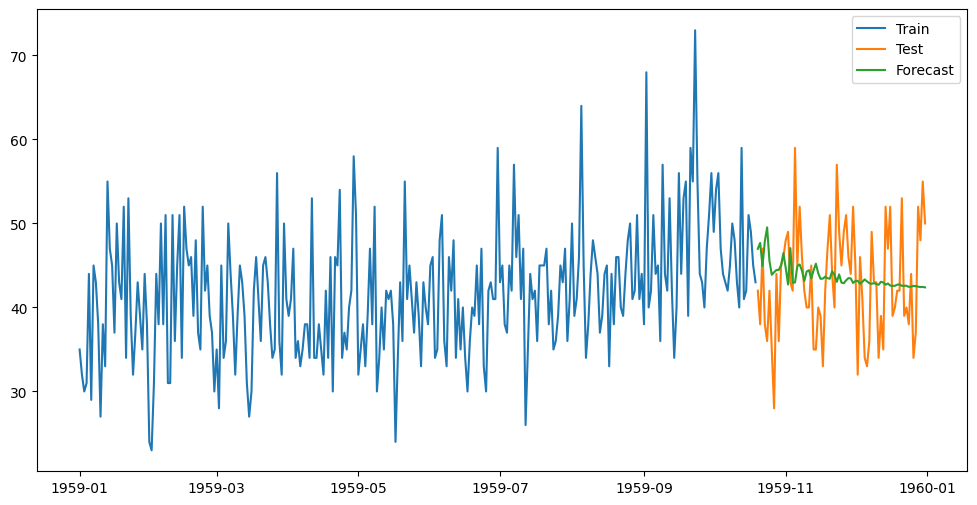

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast3, label="Forecast")
plt.legend()
plt.show()

In [20]:
print(f"mse_arma:{mse_arma}, mae_arma:{mae_arma }" )

mse_arma:47.38670894949814, mae_arma:5.553997912308551


In [21]:
# Output the results
mse_ar1, mae_ar1, mse_ma1, mae_ma1, mse_arma, mae_arma

(57.113216694345496,
 6.223773647720649,
 42.9737696738368,
 5.302526309805811,
 47.38670894949814,
 5.553997912308551)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


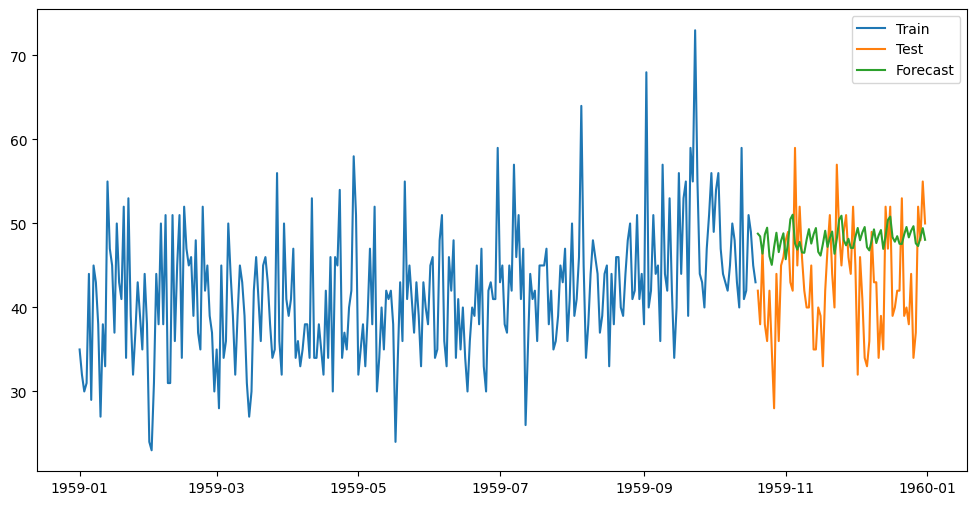

In [22]:
# SARIMA Model
order_sarima = (7, 1, 1)
seasonal_order_sarima = (1, 0, 1, 21)
model_sarima = ARIMA(train, order=order_sarima, seasonal_order=seasonal_order_sarima)
model_sarima_fit = model_sarima.fit()

forecast = model_sarima_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.legend()
plt.show()

#SARIMA is the best model
the SARIMA model has the lowest values, and a better fit.

# APPLAY support vector regressor to predict 1 step, 3 steps, and print MSE, MAE

In [29]:
test

,Births
Date,
1959-10-20,42
1959-10-21,38
1959-10-22,47
1959-10-23,38
1959-10-24,36
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [41]:
def generate_lagged_features(data, num_lags):
    df = pd.DataFrame(data)
    lagged_features = pd.concat([df.shift(i) for i in range(1, num_lags + 1)], axis=1)
    lagged_features.columns = [f'lag_{i}' for i in range(1, num_lags + 1)]
    lagged_features['y'] = data
    return lagged_features.dropna()

# Parameters
num_lags = 3  # Number of lags to create
train_ratio = 0.8

# Create lagged features
lagged_data = generate_lagged_features(train, num_lags)

# Split the data into training and testing sets
train_size = int(len(lagged_data) * train_ratio)
training_data, testing_data = lagged_data[:train_size], lagged_data[train_size:]

X_train, y_train = training_data.drop('y', axis=1), training_data['y']
X_test, y_test = testing_data.drop('y', axis=1), testing_data['y']

# Standardize the data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Train the SVR model
svr = SVR(kernel='linear', C=1)
svr.fit(X_train_scaled, y_train_scaled)

# Make 1-step ahead predictions
y_pred_1_step_scaled = svr.predict(X_test_scaled)
y_pred_1_step = y_scaler.inverse_transform(y_pred_1_step_scaled.reshape(-1, 1)).flatten()

# Make 3-steps ahead predictions using a rolling forecast method
y_pred_3_steps = []
for i in range(len(X_test_scaled) - 2):
    X_test_batch = X_test_scaled[i:i + 3]
    y_pred_batch = svr.predict(X_test_batch)
    y_pred_3_steps.append(y_pred_batch[-1])

y_pred_3_steps = y_scaler.inverse_transform(np.array(y_pred_3_steps).reshape(-1, 1)).flatten()

# Truncate y_test to match the length of y_pred_3_steps
y_test_truncated = y_test[:len(y_pred_3_steps)]

# Calculate MSE and MAE for 1-step ahead predictions
mse_1_step = mean_squared_error(y_test, y_pred_1_step)
mae_1_step = mean_absolute_error(y_test, y_pred_1_step)

# Calculate MSE and MAE for 3-steps ahead predictions
mse_3_steps = mean_squared_error(y_test_truncated, y_pred_3_steps)
mae_3_steps = mean_absolute_error(y_test_truncated, y_pred_3_steps)

print(f'1-step ahead prediction - MSE: {mse_1_step}, MAE: {mae_1_step}')
print(f'3-steps ahead prediction - MSE: {mse_3_steps}, MAE: {mae_3_steps}')

1-step ahead prediction - MSE: 111.03621467366506, MAE: 7.912591722584958
3-steps ahead prediction - MSE: 121.58273949060818, MAE: 8.355927089731361


## Plot actual vs prediction

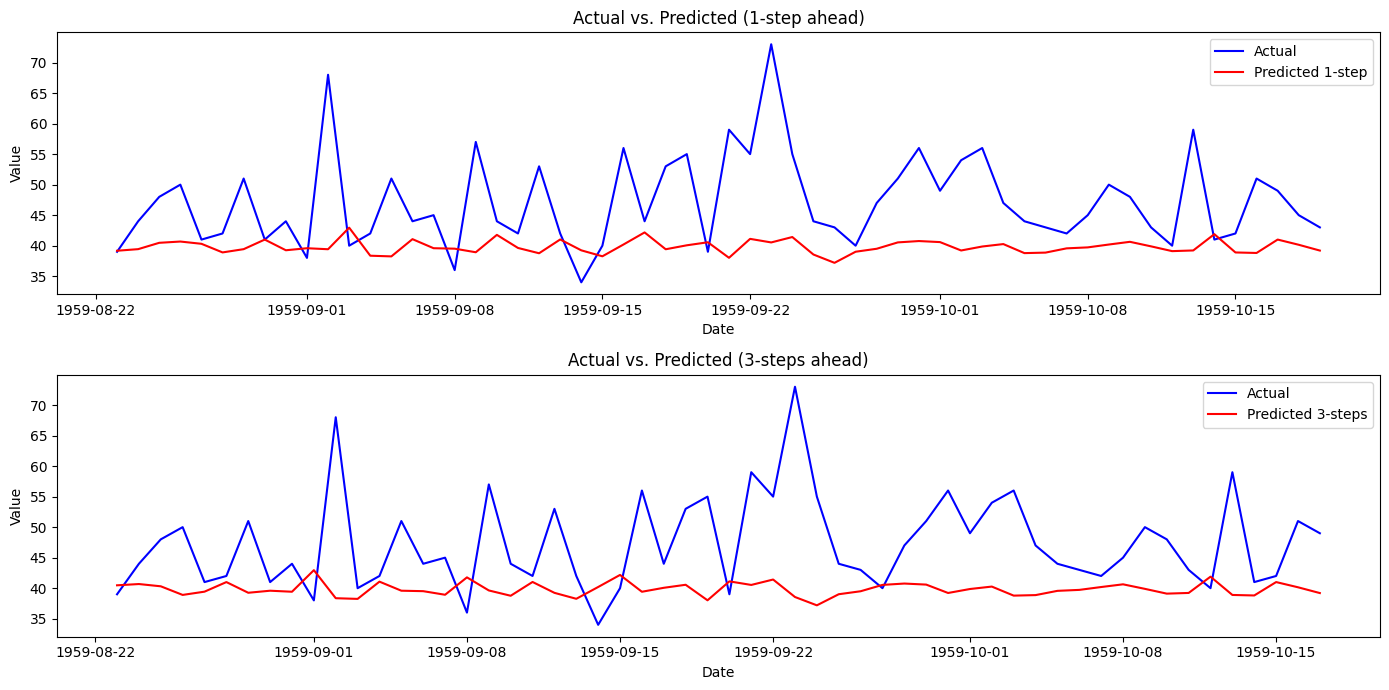

In [42]:
# Plot the results
plt.figure(figsize=(14, 7))

# 1-step ahead prediction plot
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_1_step, label='Predicted 1-step', color='red')
plt.title('Actual vs. Predicted (1-step ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# 3-steps ahead prediction plot
plt.subplot(2, 1, 2)
plt.plot(y_test.index[:len(y_pred_3_steps)], y_test_truncated, label='Actual', color='blue')
plt.plot(y_test.index[:len(y_pred_3_steps)], y_pred_3_steps, label='Predicted 3-steps', color='red')
plt.title('Actual vs. Predicted (3-steps ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


## applay LSTM or RNN to predict the next step and print MSE
## Plot actual vs. prediction

In [ ]:
# Prepare the data for LSTM
train_values = train['Births'].values
test_values = test['Births'].values

def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        X.append(a)
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 1
X_train, y_train = create_dataset(train_values, look_back)
X_test, y_test = create_dataset(test_values, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict the next step
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate MSE
mse_lstm = mean_squared_error(y_test, test_predict)
mse_lstm

Epoch 1/100
290/290 - 3s - loss: 1274.7410 - 3s/epoch - 9ms/step
Epoch 2/100
290/290 - 1s - loss: 511.4993 - 738ms/epoch - 3ms/step
Epoch 3/100
290/290 - 1s - loss: 200.3741 - 678ms/epoch - 2ms/step
Epoch 4/100
290/290 - 1s - loss: 98.2634 - 705ms/epoch - 2ms/step
Epoch 5/100
290/290 - 1s - loss: 66.3666 - 745ms/epoch - 3ms/step
Epoch 6/100
290/290 - 1s - loss: 58.4032 - 725ms/epoch - 3ms/step
Epoch 7/100
290/290 - 1s - loss: 56.8629 - 1s/epoch - 4ms/step
Epoch 8/100
290/290 - 1s - loss: 56.7707 - 1s/epoch - 4ms/step
Epoch 9/100
290/290 - 1s - loss: 55.8858 - 1s/epoch - 4ms/step
Epoch 10/100
290/290 - 1s - loss: 55.5679 - 964ms/epoch - 3ms/step
Epoch 11/100
290/290 - 1s - loss: 55.3581 - 681ms/epoch - 2ms/step
Epoch 12/100
290/290 - 1s - loss: 54.7252 - 722ms/epoch - 2ms/step
Epoch 13/100
290/290 - 1s - loss: 55.1427 - 731ms/epoch - 3ms/step
Epoch 14/100
290/290 - 1s - loss: 55.0904 - 803ms/epoch - 3ms/step
Epoch 15/100
290/290 - 1s - loss: 54.9892 - 779ms/epoch - 3ms/step
Epoch 16/100

40.61044163907621

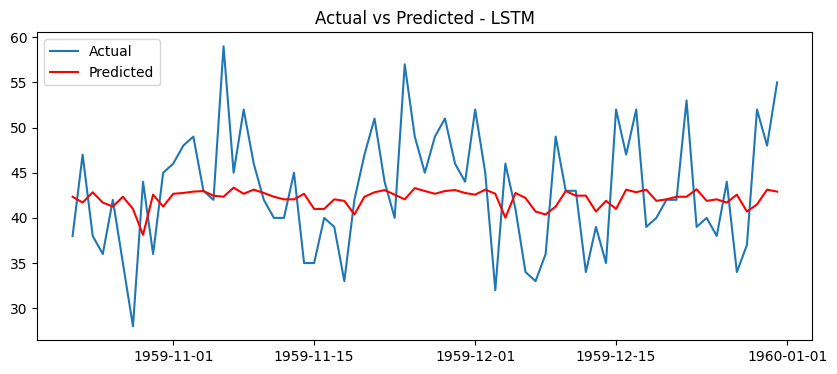

In [ ]:
# Plot actual vs prediction
plt.figure(figsize=(10, 4))
plt.plot(test.index[look_back+1:], y_test, label='Actual')
plt.plot(test.index[look_back+1:], test_predict, label='Predicted', color='red')
plt.legend(loc='upper left')
plt.title('Actual vs Predicted - LSTM')
plt.show()


#Try to apply minmaxscaler on data

In [ ]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM (reshape data for LSTM)
train_reshaped = train_scaled.reshape((train_scaled.shape[0], 1, train_scaled.shape[1]))
test_reshaped = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[1]))


In [ ]:
# Fit the LSTM model
history = lstm_model.fit(train_reshaped, train_scaled, epochs=50, batch_size=1, verbose=1)

# Predict on the test data
predictions = lstm_model.predict(test_reshaped)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get back to the original scale

# Calculate MSE and MAE for LSTM predictions
mse_lstm = mean_squared_error(test.values, predictions)
mae_lstm = mean_absolute_error(test.values, predictions)
print('LSTM MSE:', mse_lstm)
print('LSTM MAE:', mae_lstm)



Epoch 1/50
292/292 [==============================] - 3s 4ms/step - loss: 0.0420
Epoch 2/50
292/292 [==============================] - 1s 5ms/step - loss: 0.0075
Epoch 3/50
292/292 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 4/50
292/292 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 5/50
292/292 [==============================] - 1s 4ms/step - loss: 7.1531e-04
Epoch 6/50
292/292 [==============================] - 1s 3ms/step - loss: 2.3763e-04
Epoch 7/50
292/292 [==============================] - 1s 3ms/step - loss: 1.4412e-04
Epoch 8/50
292/292 [==============================] - 1s 3ms/step - loss: 1.2496e-04
Epoch 9/50
292/292 [==============================] - 1s 3ms/step - loss: 1.3414e-04
Epoch 10/50
292/292 [==============================] - 1s 3ms/step - loss: 1.2289e-04
Epoch 11/50
292/292 [==============================] - 1s 3ms/step - loss: 1.2131e-04
Epoch 12/50
292/292 [==============================] - 1s 3ms/step - loss: 1.21

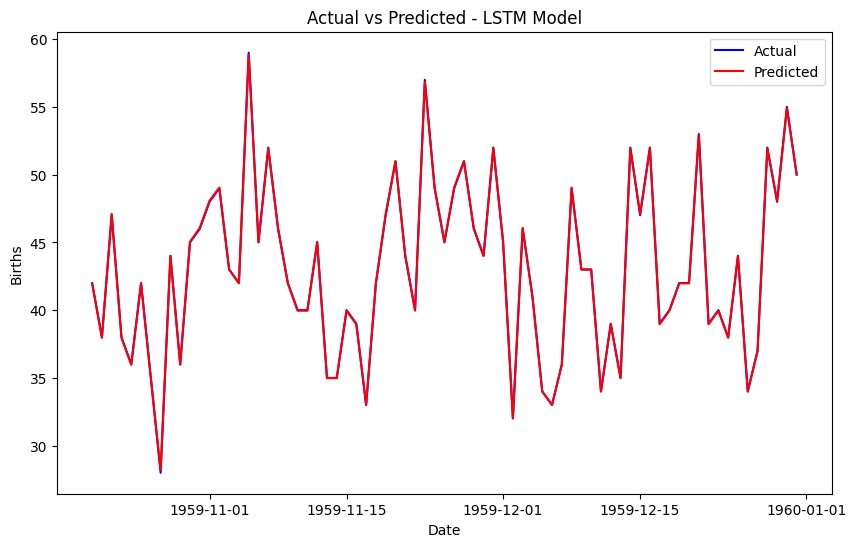

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted - LSTM Model')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.show()
#there is an overfitting:(!